In [6]:
import scipy.io
import matplotlib.pyplot as plt
Xmat = scipy.io.loadmat('X.mat')
Ymat = scipy.io.loadmat('Y.mat')

In [9]:
X = Xmat["X"]
GT = Ymat['Y']

In [8]:
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()

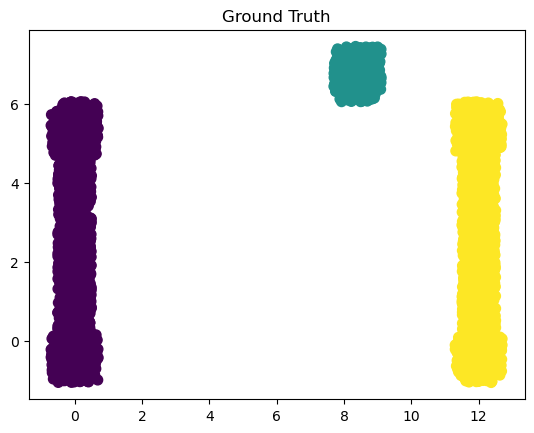

In [10]:
plot_clusters(X, GT, "Ground Truth")